In [52]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from math import radians, sin, cos, asin, sqrt

# -----------------------
# Parameters (scenario-tuned)
# -----------------------
@dataclass
class Params:
    # Demand / attendance model
    pmin: float = 5
    pmax: float = 250
    pstep: float = 2
    A0: float = 2000.0     # base demand scale (scenario)
    xi: float = 0.02       # brand sensitivity
    zeta: float = 0.02     # quality sensitivity
    eps: float = 1.2       # price elasticity (positive; demand uses p^-eps)

    # Revenue add-ons (scenario)
    a: float = 8.0         # ancillary $ per attendee
    mu: float = 5000.0     # sponsorship/media scaling with brand (per period)

    # Brand dynamics
    rho: float = 0.15
    alpha: float = 0.05    # wins effect
    beta: float = 0.02     # popularity effect
    gamma: float = 0.0003  # marketing effect

    # Costs / finance (scenario)
    Ot: float = 150000.0   # operations cost per period (placeholder)
    r0: float = 0.05
    rM: float = 0.03
    rL: float = 0.02       # leverage premium multiplier

    # Leverage policy thresholds
    Cmin: float = 200000.0
    Ctarget: float = 500000.0
    d_plus: float = 50000.0
    d_minus: float = 50000.0
    forecast_k: int = 3    # lookback for profit forecast

    # Roster objective weights (owner value)
    wb: float = 1.0
    ws: float = 0.4
    wr: float = 1.0

    # Roster imbalance penalty
    eta: float = 0.0

    # Injury trigger
    key_injury_threshold: float = 0.35  # if key player's pi goes above this => trigger
    key_player_name: str = ""           # set this if you want a specific trigger

    # Expansion
    delta_c: float = 0.08   # salary inflation if Et=1
    delta_league: float = 0.10
    delta_sub: float = 0.12
    tau: float = 800.0      # distance decay (km)

def haversine_km(lat1, lon1, lat2, lon2):
    # returns distance in km
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

def imbalance_penalty(roster_df, desired=None):
    # Simple optional penalty: L1 distance to desired position mix
    # If you don't have desired mix, return 0.
    if desired is None or "position" not in roster_df.columns:
        return 0.0
    counts = roster_df["position"].value_counts().to_dict()
    pen = 0.0
    for pos, target in desired.items():
        pen += abs(counts.get(pos, 0) - target)
    return pen


In [53]:
def load_candidates_and_assets(EXCEL_PATH: str, players_model: pd.DataFrame):
    xl = pd.ExcelFile(EXCEL_PATH)
    sheets = set(xl.sheet_names)

    if "candidates" in sheets:
        candidates = pd.read_excel(EXCEL_PATH, sheet_name="candidates")
    else:
        candidates = players_model.copy()
        candidates["acq_channel"] = "keep"
        candidates["asset_cost"] = 0.0

    if "assets" in sheets:
        assets = pd.read_excel(EXCEL_PATH, sheet_name="assets")
        if len(assets) == 0:
            assets = pd.DataFrame([{"draft_picks_owned": 1, "trade_asset_budget": 1.0}])
    else:
        assets = pd.DataFrame([{"draft_picks_owned": 1, "trade_asset_budget": 1.0}])

    # normalize keys
    for df in [candidates]:
        df["player_name"] = df["player_name"].astype(str).str.strip()
        if "acq_channel" in df.columns:
            df["acq_channel"] = df["acq_channel"].astype(str).str.strip().str.lower()

    # fill missing columns expected by optimizer
    for col in ["salary", "perf_score", "injury_risk", "popularity_score", "asset_cost"]:
        if col not in candidates.columns:
            candidates[col] = np.nan
    candidates["asset_cost"] = candidates["asset_cost"].fillna(0.0)

    return candidates, assets.iloc[0].to_dict()


In [54]:
def solve_roster_milp(candidates: pd.DataFrame,
                     league: pd.DataFrame,
                     assets_row: dict,
                     params: Params,
                     allow_waivers: bool = False):
    """
    PuLP-free heuristic roster selection:
    - maximize player value under salary cap
    - respect roster size bounds
    - respect draft_picks_owned and trade_asset_budget
    """

    cap = float(league.loc[0, "salary_cap"])
    rmin = int(league.loc[0, "min_roster_size"])
    rmax = int(league.loc[0, "max_roster_size"])

    df = candidates.copy()

    # Waivers only allowed if injury trigger occurs
    if not allow_waivers and "acq_channel" in df.columns:
        df = df[df["acq_channel"].ne("waiver")].copy()

    # Ensure columns exist
    for col in ["acq_channel", "asset_cost", "salary", "perf_score", "injury_risk", "popularity_score"]:
        if col not in df.columns:
            df[col] = 0.0 if col != "acq_channel" else "keep"

    # Clean numeric fields
    df["salary"] = pd.to_numeric(df["salary"], errors="coerce").fillna(0.0)
    df["perf_score"] = pd.to_numeric(df["perf_score"], errors="coerce").fillna(0.0)
    df["injury_risk"] = pd.to_numeric(df["injury_risk"], errors="coerce").fillna(0.0).clip(0, 1)
    df["popularity_score"] = pd.to_numeric(df["popularity_score"], errors="coerce").fillna(0.0)
    df["asset_cost"] = pd.to_numeric(df["asset_cost"], errors="coerce").fillna(0.0)
    df["acq_channel"] = df["acq_channel"].astype(str).str.lower().str.strip()

    # Owner value per player
    df["value"] = params.wb*df["perf_score"] + params.ws*df["popularity_score"] - params.wr*df["injury_risk"]

    draft_picks = int(assets_row.get("draft_picks_owned", 1))
    trade_budget = float(assets_row.get("trade_asset_budget", 1.0))

    # Sort by value-per-dollar (handle salary=0)
    df["vpd"] = df["value"] / (df["salary"] + 1.0)

    # Greedy selection with constraints
    chosen_idx = []
    total_salary = 0.0
    used_draft = 0
    used_trade_budget = 0.0

    # Prefer high vpd first
    for i, row in df.sort_values("vpd", ascending=False).iterrows():
        if len(chosen_idx) >= rmax:
            continue

        ch = row["acq_channel"]
        sal = float(row["salary"])
        cost = float(row["asset_cost"])

        if total_salary + sal > cap:
            continue
        if ch == "draft" and used_draft + 1 > draft_picks:
            continue
        if ch == "trade" and used_trade_budget + cost > trade_budget:
            continue

        chosen_idx.append(i)
        total_salary += sal
        if ch == "draft":
            used_draft += 1
        if ch == "trade":
            used_trade_budget += cost

    # If we didn't reach rmin, fill with cheapest feasible players
    if len(chosen_idx) < rmin:
        remaining = df.drop(index=chosen_idx).copy()
        remaining = remaining.sort_values("salary", ascending=True)

        for i, row in remaining.iterrows():
            if len(chosen_idx) >= rmin:
                break
            sal = float(row["salary"])
            ch = row["acq_channel"]
            cost = float(row["asset_cost"])

            if total_salary + sal > cap:
                continue
            if ch == "draft" and used_draft + 1 > draft_picks:
                continue
            if ch == "trade" and used_trade_budget + cost > trade_budget:
                continue

            chosen_idx.append(i)
            total_salary += sal
            if ch == "draft":
                used_draft += 1
            if ch == "trade":
                used_trade_budget += cost

    chosen = df.loc[chosen_idx].copy()
    chosen_value = float(chosen["value"].sum())

    return {
        "status": "HEURISTIC_OK",
        "roster": chosen.sort_values("value", ascending=False),
        "total_salary": float(chosen["salary"].sum()),
        "total_value": chosen_value
    }


In [55]:
def attendance(capacity, A0, B, Q, p, params: Params):
    # Att(p) = min(Cap, A0 * exp(xi*B + zeta*Q) * p^(-eps))
    demand = A0 * np.exp(params.xi*B + params.zeta*Q) * (p ** (-params.eps))
    return float(min(capacity, demand))

def choose_price(capacity, A0, B, Q, params: Params):
    best = None
    for p in np.arange(params.pmin, params.pmax + 1e-9, params.pstep):
        att = attendance(capacity, A0, B, Q, p, params)
        rev = (p + params.a) * att
        if best is None or rev > best["rev"]:
            best = {"p": float(p), "att": float(att), "rev": float(rev)}
    return best


In [56]:
def leverage_policy(C, Mt, profit_hist, params: Params):
    k = min(params.forecast_k, len(profit_hist))
    forecast = np.mean(profit_hist[-k:]) if k > 0 else 0.0

    # If cash is low OR macro stress is on, BORROW to protect liquidity
    if (C < params.Cmin) or (Mt == 1):
        return +params.d_plus

    # If cash is healthy and forecast is positive, PAY DOWN debt
    if (C >= params.Ctarget) and (forecast > 0):
        return -params.d_minus

    return 0.0


def apply_expansion(B_next, Et, team_lat, team_lon, expansion_lat, expansion_lon, params: Params):
    if Et != 1:
        return B_next
    # Brand update: +delta_league - delta_sub * exp(-d/tau)
    if expansion_lat is None or expansion_lon is None or team_lat is None or team_lon is None:
        overlap_term = 0.0
    else:
        d = haversine_km(team_lat, team_lon, expansion_lat, expansion_lon)
        overlap_term = np.exp(-d / params.tau)
    return B_next + params.delta_league - params.delta_sub * overlap_term

def run_season_simulation(EXCEL_PATH: str,
                          players_model: pd.DataFrame,
                          league: pd.DataFrame,
                          teams: pd.DataFrame,
                          params: Params,
                          scenario: dict):
    """
    scenario keys (examples):
      - team_name: "Fever"
      - T: 11 (weeks)
      - Mt_schedule: list of 0/1 length T
      - Et: 0/1
      - expansion_team_lat/lon: floats or None
      - C0, D0, B0, V0: floats
      - desired_pos_mix: dict like {"G":4,"F":4,"C":3} or None
      - injury_shock_week: int or None
      - key_player_name: str or ""
    """
    team_name = str(scenario.get("team_name", "Fever"))
    T = int(scenario.get("T", 11))
    Et = int(scenario.get("Et", 0))

    Mt_schedule = scenario.get("Mt_schedule", [0]*T)
    Mt_schedule = (Mt_schedule + [0]*T)[:T]

    C = float(scenario.get("C0", 500000.0))
    D = float(scenario.get("D0", 200000.0))
    B = float(scenario.get("B0", 10.0))
    V = float(scenario.get("V0", 50_000_000.0))  # franchise value (scenario)

    desired_pos_mix = scenario.get("desired_pos_mix", None)

    injury_shock_week = scenario.get("injury_shock_week", None)
    key_player = scenario.get("key_player_name", params.key_player_name)

    # team info
    trow = teams.copy()
    trow["team"] = trow["team"].astype(str).str.strip()
    this_team = trow[trow["team"].str.lower() == team_name.lower()]
    if len(this_team) == 0:
        # fallback defaults
        capacity = 18274
        home_games = 22
        team_lat = None
        team_lon = None
    else:
        r = this_team.iloc[0]
        capacity = int(r.get("arena_capacity", 18274))
        home_games = int(r.get("home_games", 22))
        team_lat = r.get("lat", None)
        team_lon = r.get("lon", None)

    # games per week approximation
    home_games_per_week = home_games / T
    games_per_week = float(scenario.get("games_per_week", 4.0))  # total games (home+away) approximation

    # Load candidates/assets
    candidates, assets_row = load_candidates_and_assets(EXCEL_PATH, players_model)

    # Apply expansion salary inflation to candidates (if Et=1): salary <- salary*(1+delta_c*Et)
    if Et == 1:
        candidates = candidates.copy()
        candidates["salary"] = pd.to_numeric(candidates["salary"], errors="coerce")
        candidates["salary"] = candidates["salary"] * (1.0 + params.delta_c)

    # Initial roster solve (no waivers at start)
    sol = solve_roster_milp(candidates, league, assets_row, params, allow_waivers=False)
    roster = sol["roster"]

    hist = []
    profit_hist = []

    expansion_lat = scenario.get("expansion_team_lat", None)
    expansion_lon = scenario.get("expansion_team_lon", None)

    for t in range(1, T+1):
        Mt = int(Mt_schedule[t-1])

        # Injury shock: artificially worsen key player's injury risk this week
        allow_waivers = False
        if injury_shock_week is not None and t == int(injury_shock_week) and key_player:
            idx = roster["player_name"].astype(str).str.lower().eq(key_player.lower())
            if idx.any():
                roster.loc[idx, "injury_risk"] = np.clip(roster.loc[idx, "injury_risk"] + 0.25, 0, 1)
                allow_waivers = True

        # Trigger if key player crosses threshold
        if key_player:
            idx = roster["player_name"].astype(str).str.lower().eq(key_player.lower())
            if idx.any() and float(roster.loc[idx, "injury_risk"].iloc[0]) >= params.key_injury_threshold:
                allow_waivers = True

        # If triggered, re-optimize allowing waivers
        if allow_waivers:
            sol = solve_roster_milp(candidates, league, assets_row, params, allow_waivers=True)
            roster = sol["roster"]

        # Team quality: Q = sum b_i(1-pi_i) - eta*Imbalance
        roster["injury_risk"] = pd.to_numeric(roster["injury_risk"], errors="coerce").fillna(0).clip(0, 1)
        roster["perf_score"] = pd.to_numeric(roster["perf_score"], errors="coerce").fillna(0)
        roster["popularity_score"] = pd.to_numeric(roster["popularity_score"], errors="coerce").fillna(0)

        Q = float((roster["perf_score"] * (1.0 - roster["injury_risk"])).sum())
        Q -= params.eta * imbalance_penalty(roster, desired_pos_mix)

        # Marketing spend (simple rule): small spend when cash above Cmin
        m = float(max(0.0, 0.02 * max(C - params.Cmin, 0.0)))

        # Pricing decision (per week treated like per-game optimal price using current state)
        price_info = choose_price(capacity, params.A0, B, Q, params)
        p_star = price_info["p"]
        att_per_home_game = price_info["att"]
        rev_per_home_game = price_info["rev"]

        # Home games this week (approx)
        hg = home_games_per_week
        ticket_rev = hg * rev_per_home_game

        # Sponsorship/media term: + mu*B
        revenue = ticket_rev + params.mu * B

        # Payroll cost this week: approximate season payroll / T
        payroll = float(pd.to_numeric(roster["salary"], errors="coerce").fillna(0).sum())
        Wt = payroll / T

        # Interest rate r_t = r0 + rM*Mt + rL*(D/V)
        r_t = params.r0 + params.rM*Mt + params.rL*(D / max(V, 1.0))

        # Profit Π = R - W - O - m - rD
        Ot_period = params.Ot / T   # interpret Ot as season-level cost, spread across periods
        profit = revenue - Wt - Ot_period - m - r_t * D

        profit_hist.append(profit)

        # Leverage decision ΔD using policy
        dD = leverage_policy(C, Mt, profit_hist, params)
        dD = max(dD, -D)

        # Cash/debt updates: C <- C + Π + ΔD ; D <- D + ΔD
        C_next = C + profit + dD
        D_next = D + dD

        # Wins approximation (needed for brand): sample expected wins from Q
        # (simple logistic; you can replace later)
        pwin = 1.0 / (1.0 + np.exp(-0.01*(Q - 120.0)))
        wins = np.random.binomial(int(round(games_per_week)), pwin)

        # Brand update: B_{t+1} = (1-rho)B + alpha*wins + beta*sum s_i(1-pi_i) + gamma*m
        pop_term = float((roster["popularity_score"] * (1.0 - roster["injury_risk"])).sum())
        B_next = (1.0 - params.rho)*B + params.alpha*wins + params.beta*pop_term + params.gamma*m

        # Expansion adjustment to brand if Et=1
        B_next = apply_expansion(B_next, Et, team_lat, team_lon, expansion_lat, expansion_lon, params)

        hist.append({
            "week": t,
            "Et": Et,
            "Mt": Mt,
            "Q": Q,
            "B": B,
            "cash_C": C,
            "debt_D": D,
            "dD": dD,
            "marketing_m": m,
            "price_p": p_star,
            "att_home_game": att_per_home_game,
            "home_games_week": hg,
            "revenue": revenue,
            "payroll_W": Wt,
            "profit": profit,
            "wins": wins,
            "allow_waivers": int(allow_waivers),
            "roster_salary": payroll,
            "roster_value": sol.get("total_value", np.nan),
            "r_t": r_t
        })

        # Advance
        C, D, B = C_next, D_next, B_next

    hist_df = pd.DataFrame(hist)
    return hist_df, roster


In [57]:
def ensure_mechanism_sheets(EXCEL_PATH, players_model, target_team="Indiana Fever"):
    # Build candidates from your existing players_model
    cand = players_model.copy()

    # Ensure required columns exist
    needed = ["player_name","team","salary","perf_score","injury_risk","popularity_score"]
    for c in needed:
        if c not in cand.columns:
            cand[c] = np.nan

    cand["player_name"] = cand["player_name"].astype(str).str.strip()
    cand["team"] = cand["team"].astype(str).str.strip()

    # Default acquisition channel:
    # - keep if already on target team
    # - otherwise free agent (you can manually change some to trade/draft/waiver later)
    cand["acq_channel"] = np.where(
        cand["team"].str.lower() == target_team.lower(),
        "keep",
        "fa"
    )

    # Asset cost used only for trade (default 0, and we prefill for non-team stars as an example)
    cand["asset_cost"] = 0.0

    # Example: mark top 20 non-team players as "trade" candidates with an asset cost based on perf_score
    non_team = cand[cand["acq_channel"] == "fa"].copy()
    if "perf_score" in non_team.columns:
        non_team = non_team.sort_values("perf_score", ascending=False)
        top_trade_names = non_team["player_name"].head(20).tolist()
        cand.loc[cand["player_name"].isin(top_trade_names), "acq_channel"] = "trade"

        # asset_cost scaled (bigger perf => higher trade cost)
        ps = pd.to_numeric(cand["perf_score"], errors="coerce").fillna(0.0)
        cand.loc[cand["acq_channel"] == "trade", "asset_cost"] = (ps / (ps.max() + 1e-9)) * 1.0  # 0..1 budget units

    # Keep only the columns we want in the candidates sheet (clean + editable)
    candidates = cand[[
        "player_name","acq_channel","team","salary","perf_score","injury_risk","popularity_score","asset_cost"
    ]].copy()

    # Assets sheet (editable)
    assets = pd.DataFrame([{
        "draft_picks_owned": 1,
        "trade_asset_budget": 1.0
    }])

    # Expansion sheet (editable placeholder)
    expansion = pd.DataFrame([{
        "expansion_team_name": "Example Expansion Team",
        "city": "Example City",
        "lat": np.nan,
        "lon": np.nan,
        "start_week": 1  # when expansion effects begin
    }])

    # Write to Excel
    with pd.ExcelWriter(EXCEL_PATH, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        candidates.to_excel(writer, sheet_name="candidates", index=False)
        assets.to_excel(writer, sheet_name="assets", index=False)
        expansion.to_excel(writer, sheet_name="expansion", index=False)

    print("✅ Wrote sheets: candidates, assets, expansion")
    print("Next: open Excel and edit acq_channel / asset_cost / expansion lat-lon if you want realism.")


In [58]:
import pandas as pd
import numpy as np
from pathlib import Path

EXCEL_PATH = Path("../data/icm_2026_wnba_data.xlsx")  # use forward slashes
if not EXCEL_PATH.exists():
    raise FileNotFoundError(f"Excel file not found: {EXCEL_PATH.resolve()}")

def to_num_series(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(float)
    return pd.to_numeric(
        s.astype(str).str.replace(r"[\$,]", "", regex=True).str.strip(),
        errors="coerce"
    )

def build_players_model(EXCEL_PATH: Path):
    players = pd.read_excel(EXCEL_PATH, sheet_name="players")
    raw = pd.read_excel(EXCEL_PATH, sheet_name="player raw stats")  # match your sheet name
    league = pd.read_excel(EXCEL_PATH, sheet_name="league")
    teams = pd.read_excel(EXCEL_PATH, sheet_name="teams")
    teams = teams.rename(columns={"team_name": "team"})

    # clean numeric columns
    for c in ["salary", "perf_score", "injury_risk", "popularity_score", "age", "social_media_followers"]:
        if c in players.columns:
            players[c] = to_num_series(players[c])

    for c in ["points_per_game","rebounds_per_game","assists_per_game","steals_per_game",
              "blocks_per_game","turnovers_per_game","minutes_per_game","games_played"]:
        if c in raw.columns:
            raw[c] = to_num_series(raw[c])

    for c in ["season_year","salary_cap","min_roster_size","max_roster_size","total_games"]:
        if c in league.columns:
            league[c] = to_num_series(league[c])

    # perf_score calc
    raw_calc = raw.copy()
    raw_calc["perf_score_calc"] = (
        raw_calc["points_per_game"]
        + 1.2*raw_calc["rebounds_per_game"]
        + 1.5*raw_calc["assists_per_game"]
        + 3.0*(raw_calc["steals_per_game"] + raw_calc["blocks_per_game"])
        - 2.0*raw_calc["turnovers_per_game"]
    )

    # injury risk calc
    TOTAL_GAMES = int(league.loc[0, "total_games"]) if ("total_games" in league.columns and len(league) > 0 and not pd.isna(league.loc[0, "total_games"])) else 40
    raw_calc["injury_risk_calc"] = (TOTAL_GAMES - raw_calc["games_played"]) / TOTAL_GAMES

    # keys
    players["player_name"] = players["player_name"].astype(str).str.strip()
    raw_calc["player_name"] = raw_calc["player_name"].astype(str).str.strip()

    # popularity calc (if missing followers column, create NaN)
    if "social_media_followers" not in players.columns:
        players["social_media_followers"] = np.nan
    players["social_media_followers"] = to_num_series(players["social_media_followers"])
    players["popularity_score_calc"] = np.log1p(players["social_media_followers"])

    # merge into players_model
    players_model = players.merge(
        raw_calc[["player_name", "perf_score_calc", "injury_risk_calc"]],
        on="player_name", how="left"
    )

    players_model["perf_score"] = players_model.get("perf_score", np.nan).fillna(players_model["perf_score_calc"])
    players_model["injury_risk"] = players_model.get("injury_risk", np.nan).fillna(players_model["injury_risk_calc"])
    players_model["popularity_score"] = players_model.get("popularity_score", np.nan).fillna(players_model["popularity_score_calc"])

    players_model["injury_risk"] = players_model["injury_risk"].clip(0, 1)

    # cleanup helper cols
    players_model = players_model.drop(columns=["perf_score_calc", "injury_risk_calc", "popularity_score_calc"], errors="ignore")

    return players_model, league, teams

players_model, league, teams = build_players_model(EXCEL_PATH)
ensure_mechanism_sheets(EXCEL_PATH, players_model, target_team="Indiana Fever")

print("Ready:", len(players_model), "players")
print("League rows:", len(league), "Teams rows:", len(teams))


✅ Wrote sheets: candidates, assets, expansion
Next: open Excel and edit acq_channel / asset_cost / expansion lat-lon if you want realism.
Ready: 19 players
League rows: 1 Teams rows: 1


In [59]:
params = Params()
TEAM_NAME = "Indiana Fever"

baseline = dict(
    team_name=TEAM_NAME,
    T=11,
    Mt_schedule=[0]*11,
    Et=0,
    C0=500000, D0=200000, B0=10, V0=50_000_000,
    injury_shock_week=None,
    key_player_name="",
)

macro_stress = {**baseline, "Mt_schedule": [1]*11}
injury = {**baseline, "injury_shock_week": 5, "key_player_name": baseline.get("key_player_name","")}
exp_df = pd.read_excel(EXCEL_PATH, sheet_name="expansion")

expansion = {
    **baseline,
    "Et": 1,
    "expansion_team_lat": float(exp_df.loc[0, "lat"]) if "lat" in exp_df.columns and not pd.isna(exp_df.loc[0, "lat"]) else None,
    "expansion_team_lon": float(exp_df.loc[0, "lon"]) if "lon" in exp_df.columns and not pd.isna(exp_df.loc[0, "lon"]) else None,
}
# Pick a reference ticket price where you'd expect near-full attendance
p_ref = 25.0

# Pull team row
t = teams.copy()
t["team"] = t["team"].astype(str).str.strip()
row = t[t["team"].str.lower() == TEAM_NAME.lower()].iloc[0]

capacity = float(row["arena_capacity"])
target_att = float(row.get("avg_home_attendance", capacity))
target_att = min(target_att, capacity)

# Use week-1 state as reference
Q_ref = float(hist_base.loc[0, "Q"]) if "hist_base" in globals() else 6.0
B_ref = float(baseline["B0"])

# Solve for A0 in: Att = A0 * exp(xi*B + zeta*Q) * p^-eps
params.A0 = target_att * (p_ref ** params.eps) / np.exp(params.xi*B_ref + params.zeta*Q_ref)
print("New A0 =", params.A0)

hist_base, roster_base = run_season_simulation(EXCEL_PATH, players_model, league, teams, params, baseline)
# ===== Calibrate A0 to match realistic attendance =====
p_ref = 25.0  # reference ticket price

t = teams.copy()
t["team"] = t["team"].astype(str).str.strip()
row = t[t["team"].str.lower() == TEAM_NAME.lower()].iloc[0]

capacity = float(row["arena_capacity"])
target_att = float(row.get("avg_home_attendance", capacity))
target_att = min(target_att, capacity)

# Use baseline starting B0/Q proxy (Q_ref uses a fallback first run)
Q_ref = 6.0
B_ref = float(baseline["B0"])

params.A0 = target_att * (p_ref ** params.eps) / np.exp(params.xi*B_ref + params.zeta*Q_ref)
print("New A0 =", params.A0)

hist_macro, roster_macro = run_season_simulation(EXCEL_PATH, players_model, league, teams, params, macro_stress)
hist_injury, roster_injury = run_season_simulation(EXCEL_PATH, players_model, league, teams, params, injury)
hist_exp, roster_exp = run_season_simulation(EXCEL_PATH, players_model, league, teams, params, expansion)

display(hist_base.head())
display(roster_base[["player_name","acq_channel","salary","perf_score","injury_risk","popularity_score"]].head(15))


New A0 = 569257.1699622689
New A0 = 572295.2488860391


,week,Et,Mt,Q,B,cash_C,debt_D,dD,marketing_m,price_p,att_home_game,home_games_week,revenue,payroll_W,profit,wins,allow_waivers,roster_salary,roster_value,r_t
0,1,0,0,6.266136,10.000000,5.000000e+05,200000.0,-50000.0,6000.000000,23.0,18274.000000,2.0,1.182988e+06,12131.636364,1.141204e+06,0,0,133448.0,55.178742,0.05008
1,2,0,0,6.266136,10.902340,1.591204e+06,150000.0,-50000.0,27824.080000,23.0,18274.000000,2.0,1.187500e+06,12131.636364,1.126399e+06,2,0,133448.0,55.178742,0.05006
2,3,0,0,6.266136,18.316554,2.667603e+06,100000.0,-50000.0,49352.052448,27.0,17831.773004,2.0,1.339807e+06,12131.636364,1.259683e+06,0,0,133448.0,55.178742,0.05004
3,4,0,0,6.266136,30.977027,3.877285e+06,50000.0,-50000.0,73545.708995,33.0,18054.347138,2.0,1.635342e+06,12131.636364,1.533527e+06,0,0,133448.0,55.178742,0.05002
4,5,0,0,6.266136,48.996526,5.360812e+06,0.0,-0.0,103216.246824,45.0,17842.630450,2.0,2.136301e+06,12131.636364,2.007317e+06,3,0,133448.0,55.178742,0.05000


,player_name,acq_channel,salary,perf_score,injury_risk,popularity_score
14,Aerial Powers,trade,3975,18.32,0.818182,11.976666
15,Shey Peddy,trade,1987,7.91,0.795455,9.661480
11,Chloe Bibby,trade,23322,6.44,0.795455,10.633473
16,Katie Lou Samuelson,trade,95835,0.00,0.000000,11.925042
13,Bree Hall,trade,4442,0.00,0.000000,11.661354
18,Kyra Lambert,trade,3887,0.00,0.977273,8.879751


In [60]:
def summarize(hist, name):
    return pd.Series({
        "scenario": name,
        "total_profit": hist["profit"].sum(),
        "avg_profit": hist["profit"].mean(),
        "final_cash": hist["cash_C"].iloc[-1],
        "final_debt": hist["debt_D"].iloc[-1],
        "min_cash": hist["cash_C"].min(),
        "avg_price": hist["price_p"].mean(),
        "avg_attendance": hist["att_home_game"].mean(),
        "avg_brand": hist["B"].mean(),
        "avg_quality_Q": hist["Q"].mean(),
        "weeks_waivers": hist["allow_waivers"].sum(),
        "weeks_macro": hist["Mt"].sum(),
    })

summary = pd.DataFrame([
    summarize(hist_base, "baseline"),
    summarize(hist_macro, "macro_stress"),
    summarize(hist_injury, "injury"),
    summarize(hist_exp, "expansion"),
]).sort_values("total_profit", ascending=False)

display(summary)


,scenario,total_profit,avg_profit,final_cash,final_debt,min_cash,avg_price,avg_attendance,avg_brand,avg_quality_Q,weeks_waivers,weeks_macro
1,macro_stress,5.666868e+07,5.151698e+06,4.668554e+07,700000.0,500000.0,123.000000,18158.397710,144.638105,6.266136,0,11
3,expansion,5.597796e+07,5.088905e+06,4.533585e+07,0.0,500000.0,121.000000,18212.500793,136.939322,6.266136,0,0
2,injury,5.572079e+07,5.065526e+06,4.509199e+07,0.0,500000.0,120.454545,18183.692717,135.933908,6.266136,0,0
0,baseline,5.554189e+07,5.049263e+06,4.492132e+07,0.0,500000.0,120.272727,18132.408487,135.473370,6.266136,0,0


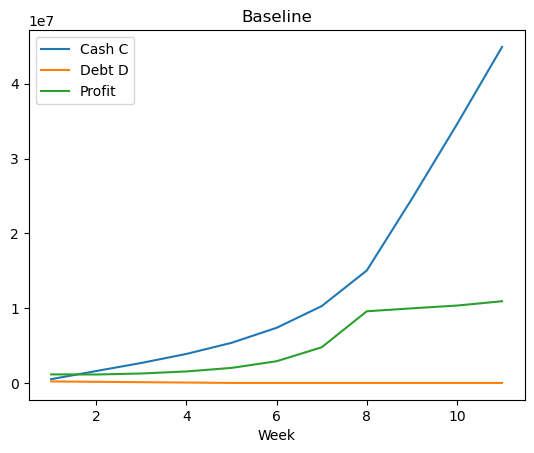

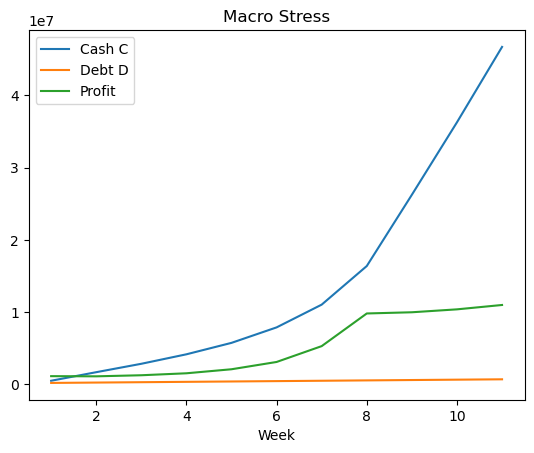

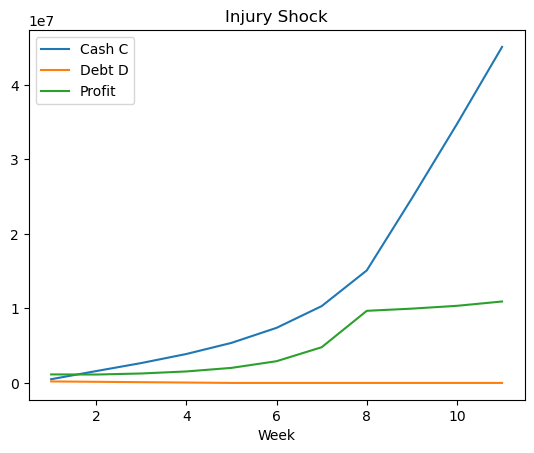

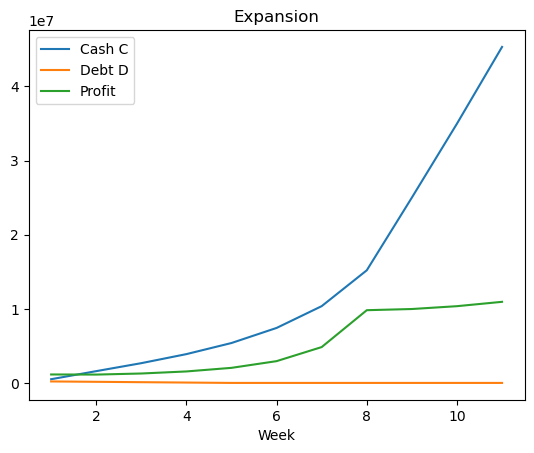

In [61]:
import matplotlib.pyplot as plt

def plot_hist(hist, title):
    plt.figure()
    plt.plot(hist["week"], hist["cash_C"], label="Cash C")
    plt.plot(hist["week"], hist["debt_D"], label="Debt D")
    plt.plot(hist["week"], hist["profit"], label="Profit")
    plt.title(title)
    plt.xlabel("Week")
    plt.legend()
    plt.show()

plot_hist(hist_base, "Baseline")
plot_hist(hist_macro, "Macro Stress")
plot_hist(hist_injury, "Injury Shock")
plot_hist(hist_exp, "Expansion")


In [62]:
cols = ["week","Q","B","price_p","att_home_game","revenue","payroll_W","marketing_m","r_t","debt_D","dD","profit","cash_C"]
display(hist_base[cols])
print("Total revenue:", hist_base["revenue"].sum())
print("Total payroll:", hist_base["payroll_W"].sum())
print("Total ops cost:", params.Ot * len(hist_base))
print("Total profit:", hist_base["profit"].sum())


,week,Q,B,price_p,att_home_game,revenue,payroll_W,marketing_m,r_t,debt_D,dD,profit,cash_C
0,1,6.266136,10.000000,23.0,18274.000000,1.182988e+06,12131.636364,6000.000000,0.05008,200000.0,-50000.0,1.141204e+06,5.000000e+05
1,2,6.266136,10.902340,23.0,18274.000000,1.187500e+06,12131.636364,27824.080000,0.05006,150000.0,-50000.0,1.126399e+06,1.591204e+06
2,3,6.266136,18.316554,27.0,17831.773004,1.339807e+06,12131.636364,49352.052448,0.05004,100000.0,-50000.0,1.259683e+06,2.667603e+06
3,4,6.266136,30.977027,33.0,18054.347138,1.635342e+06,12131.636364,73545.708995,0.05002,50000.0,-50000.0,1.533527e+06,3.877285e+06
4,5,6.266136,48.996526,45.0,17842.630450,2.136301e+06,12131.636364,103216.246824,0.05000,0.0,-0.0,2.007317e+06,5.360812e+06
5,6,6.266136,73.364262,67.0,18016.880422,3.069353e+06,12131.636364,143362.591058,0.05000,0.0,-0.0,2.900223e+06,7.368130e+06
6,7,6.266136,106.070740,115.0,18122.445985,4.988475e+06,12131.636364,201367.046680,0.05000,0.0,-0.0,4.761340e+06,1.026835e+07
7,8,6.266136,151.222584,243.0,18218.416363,9.901758e+06,12131.636364,296593.854023,0.05000,0.0,-0.0,9.579396e+06,1.502969e+07
8,9,6.266136,218.169693,249.0,18274.000000,1.048368e+07,12131.636364,488181.775597,0.05000,0.0,-0.0,9.969735e+06,2.460909e+07
9,10,6.266136,332.601112,249.0,18274.000000,1.105584e+07,12131.636364,687576.469372,0.05000,0.0,-0.0,1.034250e+07,3.457882e+07


Total revenue: 58821817.51771641
Total payroll: 133448.0
Total ops cost: 1650000.0
Total profit: 55541893.281523265


In [63]:
def run_monte_carlo(EXCEL_PATH, players_model, league, teams, params, scenario, N=200, seed=0):
    out = []
    for k in range(N):
        np.random.seed(seed + k)
        hist, roster = run_season_simulation(EXCEL_PATH, players_model, league, teams, params, scenario)
        out.append({
            "trial": k,
            "total_profit": hist["profit"].sum(),
            "final_cash": hist["cash_C"].iloc[-1],
            "final_debt": hist["debt_D"].iloc[-1],
            "min_cash": hist["cash_C"].min(),
            "bankrupt_flag": int(hist["cash_C"].min() < 0),
        })
    return pd.DataFrame(out)

mc_base = run_monte_carlo(EXCEL_PATH, players_model, league, teams, params, baseline, N=200, seed=123)
mc_macro = run_monte_carlo(EXCEL_PATH, players_model, league, teams, params, macro_stress, N=200, seed=123)

display(mc_base.describe())
print("Bankruptcy rate (baseline):", mc_base["bankrupt_flag"].mean())
print("Bankruptcy rate (macro):", mc_macro["bankrupt_flag"].mean())


,trial,total_profit,final_cash,final_debt,min_cash,bankrupt_flag
count,200.000000,2.000000e+02,2.000000e+02,200.0,200.0,200.0
mean,99.500000,5.575222e+07,4.512154e+07,0.0,500000.0,0.0
std,57.879185,4.996065e+04,4.741742e+04,0.0,0.0,0.0
min,0.000000,5.562955e+07,4.500526e+07,0.0,500000.0,0.0
25%,49.750000,5.572596e+07,4.509700e+07,0.0,500000.0,0.0
50%,99.500000,5.574765e+07,4.511744e+07,0.0,500000.0,0.0
75%,149.250000,5.577874e+07,4.514676e+07,0.0,500000.0,0.0
max,199.000000,5.592759e+07,4.528822e+07,0.0,500000.0,0.0


Bankruptcy rate (baseline): 0.0
Bankruptcy rate (macro): 0.0
